In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from skimage.transform import resize
import skimage
import pylab
pylab.rcParams['figure.figsize'] = (4.0, 4.0)
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as tvt
import torchvision
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import copy
import gc
import cv2 as cv
import json
import time
import glob

from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3
from scipy.stats import wasserstein_distance

In [4]:
Path_train = '*/pizzas/train'
Path_eval = '*/pizzas/eval'
Path_fake1 = '*/pizzas/fake1'
Path_fake2 = '*/pizzas/fake2'
Path_model = '*/Model'

In [5]:
# os.chdir(Path_train)
train_imgs = glob.glob(Path_train + '/*.jpg')
val_imgs = glob.glob(Path_eval + '/*.jpg')
fake1_imgs = glob.glob(Path_fake1 + '/*.jpg')
fake2_imgs = glob.glob(Path_fake2 + '/*.jpg')

len(train_imgs), len(val_imgs), len(fake1_imgs), len(fake2_imgs)

(8213, 1000, 1000, 0)

In [83]:
'''produce a normalized img dataset'''
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, img_names):
        super(MyDataset).__init__()
        self.folder_path = folder_path
        self.img_names = img_names

        # to tensor and normalize the image
        self.transform = tvt.Compose([tvt.ToTensor(),
                                      tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
            
    def __len__(self):
        # return total num of images
        return len(self.img_names)
    
    def __getitem__(self, index):
        # Read an image at index and perform augmentations
        path = os.path.join(self.folder_path, self.img_names[index])
        img = Image.open(path)
        
        # return the tuple: augmented tensor, integer label
        img = self.transform(img)        
       
        return img
    
'''plot 4*4 img grid produced by Net_G from random generated vectors'''    
def plot_4_img_grid(Net_G):

    noise_batch = torch.randn(16, 100) # batch_size = 16
    imgs = Net_G(noise_batch)
    img = torchvision.utils.make_grid(imgs, nrow = 4, padding=1, pad_value=1, normalize=True).permute(1, 2, 0).detach().numpy()

    plt.figure(figsize = (6,6))
    plt.imshow(img)
    
def plot_4_img_row(Net_G):

    noise_batch = torch.randn(4, 100) # batch_size = 16
    imgs = Net_G(noise_batch)
    img = torchvision.utils.make_grid(imgs, nrow = 4, padding=1, pad_value=1, normalize=True).permute(1, 2, 0).detach().numpy()

    plt.figure(figsize = (6,2))
    plt.imshow(img)

'''lot 4*4 real img grid'''
def plot_4_img_grid_real(path_imgs):

    
    all_imgs = glob.glob(path_imgs + '/*.jpg')
    all_data = MyDataset(path_imgs, all_imgs)
    
    kwargs = {'batch_size': 16,
              'shuffle': True,
              'drop_last': True}

    all_dataloader = torch.utils.data.DataLoader(dataset = all_data, **kwargs)
    
    imgs = next(iter(all_dataloader))
    img = torchvision.utils.make_grid(imgs, nrow = 4, padding=1, pad_value=1, normalize=True).permute(1, 2, 0).numpy()

    plt.figure(figsize = (6,6))
    plt.imshow(img)    
    
    
'''plot the loss_D and loss_G as a function of iteration number'''
def plot_result(loss_D, loss_G):
    plt.figure(figsize = (4,4))
    plt.plot(loss_D, label = 'Loss_D')
    plt.plot(loss_G, label = 'Loss_G')
    plt.legend()
    plt.xlabel('iteration number (*10)')
    plt.ylabel('BCE Loss')
    plt.yscale('log')
    
def plot_result_W(loss_D, loss_G):
    plt.figure(figsize = (4,4))
    plt.plot(loss_D, label = 'Loss_D')
    plt.plot(loss_G, label = 'Loss_G')
    plt.legend()
    plt.xlabel('iteration number (*10)')
    plt.ylabel('BCE Loss') 
    
'''generate fake pizza image based on the Net_G model'''    
def Generate_fake_pizza(Net_G, img_num, Path_fake):
    batch_size = 100
    num_ch_noise = 100
    count = 0
    
    epochs = img_num//batch_size + 1
    
    for i in range(epochs):
        # noise_batch = torch.randn(batch_size, num_ch_noise, 1, 1, device = device)
        noise_batch = torch.randn(batch_size, num_ch_noise, device = device)
        imgs = Net_G(noise_batch)

        for img in imgs:
            count += 1
            if count > img_num:
                break
            file_name = str(count) + '.jpg'
            img_np = img.permute(1, 2, 0).detach().numpy()
            img_new = (img_np*128 + 128).astype(np.uint8)

            os.chdir(Path_fake)
            io.imsave(file_name,img_new)

# generator, discriminator and critic

In [8]:
# discriminator

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1)
        self.extra = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 2, padding = 0)
        
        self.bn0 = nn.BatchNorm2d(64)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn0(self.extra(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn1(self.conv2(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn2(self.conv3(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn3(self.conv4(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.conv5(x)
        x = self.sigmoid(x)
        
        return x
    
class Critic(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1)
        self.extra = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 2, padding = 0)
        
        self.bn0 = nn.BatchNorm2d(64)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        
#         self.linear = self.Linear()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn0(self.extra(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn1(self.conv2(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn2(self.conv3(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.bn3(self.conv4(x))
        x = F.leaky_relu(x, negative_slope = 0.2, inplace = True)
        x = self.conv5(x)
        
#         x = x.view(-1)
#         x = self.linear(x)
#         x = self.sigmoid(x)
        x = self.tanh(x)
        x = x.view(1,-1)
        
        return x
    
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.convT1 = nn.ConvTranspose2d(100, 512, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT4 = nn.ConvTranspose2d(128,  64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT5 = nn.ConvTranspose2d(64 ,   3, kernel_size = 4, stride = 2, padding = 1, bias = False)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        x = self.bn1(self.convT1(x))
        x = F.relu(x)
        
        x = self.bn2(self.convT2(x))
        x = F.relu(x)
        
        x = self.bn3(self.convT3(x))
        x = F.relu(x)
        
        x = self.bn4(self.convT4(x))
        x = F.relu(x)
        
        x = self.convT5(x)
        x = self.tanh(x)
        
        return x 
    
class Generator_FC(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(100, 64, bias = False)
        self.linear2 = nn.Linear(64, 512, bias = False)
        self.linear3 = nn.Linear(512, 8192, bias = False)
        self.bn5 = nn.BatchNorm1d(8192)
        
        self.convT1 = nn.ConvTranspose2d(100, 512, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT4 = nn.ConvTranspose2d(128,  64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.convT5 = nn.ConvTranspose2d(64 ,   3, kernel_size = 4, stride = 2, padding = 1, bias = False)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.bn5(self.linear3(x))
        x = torch.reshape(x, (x.shape[0], x.shape[1]//16, 4, 4))
#         x = self.bn1(self.convT1(x))
#         x = F.relu(x)
        
        x = self.bn2(self.convT2(x))
        x = F.relu(x)
        
        x = self.bn3(self.convT3(x))
        x = F.relu(x)
        
        x = self.bn4(self.convT4(x))
        x = F.relu(x)
        
        x = self.convT5(x)
        x = self.tanh(x)
        
        return x 
    
class test(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 4, stride = 2, padding = 1)
        self.bn0= nn.BatchNorm2d(10)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn0(x)
        return x
    

In [10]:
Net_G = Generator()
Net_D = Discriminator()

train_data = MyDataset(Path_train, train_imgs)

kwargs = {'batch_size': 100,
          'shuffle': True,
          'drop_last': True}

train_dataloader = torch.utils.data.DataLoader(dataset = train_data, **kwargs)

test_data = MyDataset(Path_eval, val_imgs)

kwargs = {'batch_size': 100,
          'shuffle': True,
          'drop_last': True}

test_dataloader = torch.utils.data.DataLoader(dataset = test_data, **kwargs)

# create dataloader and plot real pizza images

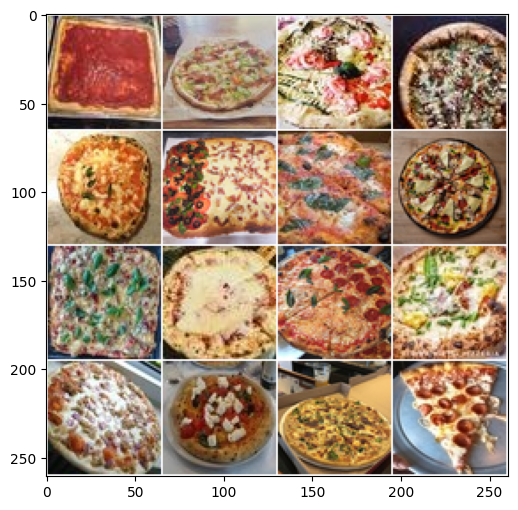

In [57]:
plot_4_img_grid_real(Path_train)

In [46]:
def run_training(train_dataloader, batch_size, lr , epochs, train_data):
    gc.collect()
    per_iter_num = 10 # iterations
    start_time = time.time()
    
    num_ch_noise = 100
    Net_D = Discriminator().to(device)
    Net_G = Generator().to(device)
    
#     Net_D.apply(self.weights_init)
#     Net_G.apply(self.weights_init)
    
    kwargs = {'batch_size': batch_size,
              'shuffle': True,
              'drop_last': True}

    train_dataloader = torch.utils.data.DataLoader(dataset = train_data, **kwargs)
    
    
    noise_batch = torch.randn(batch_size, num_ch_noise, 1, 1, device = device)
    
    label_real = 1
    label_fake = 0
    
    optimizer_D = torch.optim.Adam(Net_D.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_G = torch.optim.Adam(Net_G.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    
    loss_D = []
    loss_G = []
    
    for epoch in range(epochs):
        loss_running_D = []
        loss_running_G = []
        
        for i, data in enumerate(train_dataloader):
            
            Net_D.zero_grad()
            
            img_real_batch = data.to(device)
            batch_size_run = img_real_batch.shape[0]
            
            label = torch.full((batch_size_run, ), 1.0, dtype = torch.float, device = device)
            output_real = Net_D(img_real_batch).view(-1)
            
            loss_D_real = criterion(output_real, label)
            loss_D_real.backward(retain_graph=True)
            
            data_noise = torch.randn(batch_size_run, num_ch_noise, 1, 1, device = device)
            img_fake_batch = Net_G(data_noise)
            label.fill_(0.0)
            
            output_fake = Net_D(img_fake_batch).view(-1)
            loss_D_fake = criterion(output_fake, label)
            loss_D_fake.backward(retain_graph=True)
            
            loss_running_D.append(loss_D_real.item() + loss_D_fake.item())
            optimizer_D.step()
            
            Net_G.zero_grad()
            
            label.fill_(1.0)
            output_fake_G = Net_D(img_fake_batch).view(-1)
            loss_G_fake = criterion(output_fake_G, label)
            
            loss_running_G.append(loss_G_fake.item())
            loss_G_fake.backward()
            optimizer_G.step()
            
            if i%per_iter_num == 0:
                loss_D.append(sum(loss_running_D)/len(loss_running_D))
                loss_G.append(sum(loss_running_G)/len(loss_running_G))
                loss_running_D = []
                loss_ruuning_G = []
                
                print('[epoch: %d, batch: %d] train D loss: %.3f'%(epoch+1, i+1, loss_D[-1]),
                      '******** train G loss: %.3f'%(loss_G[-1])
                       )
                
    end_time = time.time()
    print('\n Runtime of this program: ', end_time - start_time)
    gc.collect()            
    return Net_D, Net_G, loss_D, loss_G


def run_training_FC(train_dataloader, batch_size, lr , epochs, train_data):
    gc.collect()
    per_iter_num = 10 # iterations
    start_time = time.time()
    
    num_ch_noise = 100
    Net_D = Discriminator().to(device)
    Net_G = Generator_FC().to(device)
    
    kwargs = {'batch_size': batch_size,
              'shuffle': True,
              'drop_last': True}

    train_dataloader = torch.utils.data.DataLoader(dataset = train_data, **kwargs)
    
    
    noise_batch = torch.randn(batch_size, num_ch_noise, device = device)
    
    label_real = 1
    label_fake = 0
    
    optimizer_D = torch.optim.Adam(Net_D.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_G = torch.optim.Adam(Net_G.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    
    loss_D = []
    loss_G = []
    
    for epoch in range(epochs):
        loss_running_D = []
        loss_running_G = []
        
        for i, data in enumerate(train_dataloader):
            
            # net_D, real images
            Net_D.zero_grad()
            
            img_real_batch = data.to(device)
            batch_size_run = img_real_batch.shape[0]
            
            label = torch.full((batch_size_run, ), 1.0, dtype = torch.float, device = device)
            output_real = Net_D(img_real_batch).view(-1)
            
            loss_D_real = criterion(output_real, label)
            loss_D_real.backward(retain_graph=True)
            
            # net_D, fake images
            data_noise = torch.randn(batch_size_run, num_ch_noise, device = device)
            img_fake_batch = Net_G(data_noise)
            label.fill_(0.0)
            
            output_fake = Net_D(img_fake_batch).view(-1)
            loss_D_fake = criterion(output_fake, label)
            loss_D_fake.backward(retain_graph=True)
            
            loss_running_D.append(loss_D_real.item() + loss_D_fake.item())
            optimizer_D.step()
            
            # Net_G, random data
            Net_G.zero_grad()
            
            label.fill_(1.0)
            output_fake_G = Net_D(img_fake_batch).view(-1)
            loss_G_fake = criterion(output_fake_G, label)
            
            loss_running_G.append(loss_G_fake.item())
            loss_G_fake.backward()
            optimizer_G.step()
            
            if i%per_iter_num == 0:
                loss_D.append(sum(loss_running_D)/len(loss_running_D))
                loss_G.append(sum(loss_running_G)/len(loss_running_G))
                loss_running_D = []
                loss_ruuning_G = []
                
                print('[epoch: %d, batch: %d] train D loss: %.3f'%(epoch+1, i+1, loss_D[-1]),
                      '******** train G loss: %.3f'%(loss_G[-1])
                       )
        
        # save model for each epoch
        Path_model_G = Path_model + '/BCE2/Net_G_epoch_' + str(epoch) + '.pt'
        Path_model_D = Path_model + '/BCE2/Net_D_epoch_' + str(epoch) + '.pt'
        
        model_scripted_G = torch.jit.script(Net_G) # Export to TorchScript
        model_scripted_G.save(Path_model_G)
        
        model_scripted_D = torch.jit.script(Net_D) # Export to TorchScript
        model_scripted_D.save(Path_model_D)
                
    end_time = time.time()
    print('\n Runtime of this program: ', end_time - start_time)
    gc.collect()            
    return Net_D, Net_G, loss_D, loss_G

# Train BCE GAN

In [39]:
Net_D, Net_G, loss_D, loss_G = run_training_FC(train_dataloader, 100, 2e-4, 15, train_data)

[epoch: 1, batch: 1] train D loss: 1.411 ******** train G loss: 2.598
[epoch: 1, batch: 11] train D loss: 0.425 ******** train G loss: 5.221
[epoch: 1, batch: 21] train D loss: 0.248 ******** train G loss: 7.849
[epoch: 1, batch: 31] train D loss: 0.243 ******** train G loss: 8.348
[epoch: 1, batch: 41] train D loss: 0.454 ******** train G loss: 7.903
[epoch: 1, batch: 51] train D loss: 0.599 ******** train G loss: 7.434
[epoch: 1, batch: 61] train D loss: 0.363 ******** train G loss: 7.027
[epoch: 1, batch: 71] train D loss: 0.281 ******** train G loss: 6.728
[epoch: 1, batch: 81] train D loss: 1.147 ******** train G loss: 6.546
[epoch: 2, batch: 1] train D loss: 0.224 ******** train G loss: 2.105
[epoch: 2, batch: 11] train D loss: 0.522 ******** train G loss: 3.380
[epoch: 2, batch: 21] train D loss: 0.742 ******** train G loss: 3.659
[epoch: 2, batch: 31] train D loss: 1.024 ******** train G loss: 3.547
[epoch: 2, batch: 41] train D loss: 1.049 ******** train G loss: 3.403
[epoch: 

[epoch: 13, batch: 81] train D loss: 0.259 ******** train G loss: 5.240
[epoch: 14, batch: 1] train D loss: 0.598 ******** train G loss: 2.464
[epoch: 14, batch: 11] train D loss: 1.505 ******** train G loss: 5.128
[epoch: 14, batch: 21] train D loss: 0.444 ******** train G loss: 4.113
[epoch: 14, batch: 31] train D loss: 0.765 ******** train G loss: 4.146
[epoch: 14, batch: 41] train D loss: 0.270 ******** train G loss: 4.038
[epoch: 14, batch: 51] train D loss: 0.095 ******** train G loss: 4.311
[epoch: 14, batch: 61] train D loss: 0.238 ******** train G loss: 4.389
[epoch: 14, batch: 71] train D loss: 0.926 ******** train G loss: 4.364
[epoch: 14, batch: 81] train D loss: 0.557 ******** train G loss: 4.308
[epoch: 15, batch: 1] train D loss: 2.408 ******** train G loss: 6.126
[epoch: 15, batch: 11] train D loss: 0.494 ******** train G loss: 4.263
[epoch: 15, batch: 21] train D loss: 0.530 ******** train G loss: 4.089
[epoch: 15, batch: 31] train D loss: 0.133 ******** train G loss: 

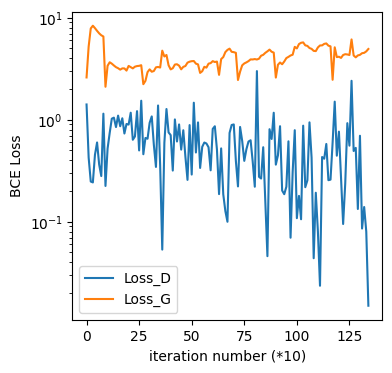

In [43]:
plot_result(loss_D, loss_G)

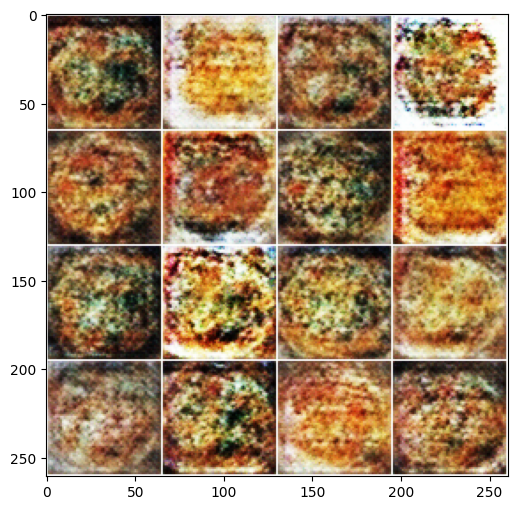

In [67]:
# load model and plot fake pizza
Path_model_G = Path_model + '/BCE/Net_G_epoch_' + str(11) + '.pt'

os.chdir(Path_model)
Net_G = torch.jit.load(Path_model_G)
Net_G.eval();

plot_4_img_grid(Net_G)

### Save and load model

In [142]:
# save and load model

'''Save model'''
# os.chdir(Path_model)
# model_scripted_G = torch.jit.script(Net_G) # Export to TorchScript
# model_scripted_G.save('Net_G_2.pt') # Save

# os.chdir(Path_model)
# model_scripted_D = torch.jit.script(Net_D) # Export to TorchScript
# model_scripted_D.save('Net_D_2.pt') # Save


'''load model'''
os.chdir(Path_model)
Net_G = torch.jit.load('Net_G_1.pt')
Net_G.eval();

Net_D = torch.jit.load('Net_D_1.pt')
Net_D.eval();

# Evaluate the GAN - BCE loss

In [47]:
def calculate_FID(path_real, path_fake, dims):
    block_index = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_index]).to(device)
    
    os.chdir(path_real)
    imgs_real = glob.glob('*.jpg')
    m1, s1 = calculate_activation_statistics(imgs_real, model, device = device)
    
    os.chdir(path_fake)
    imgs_fake = glob.glob('*.jpg')
    m2, s2 = calculate_activation_statistics(imgs_fake, model, device = device)
    
    fid_value = calculate_frechet_distance(m1,s1,m2,s2)
    print(f'FID: {fid_value:.2f}')


calculate_FID(path_real = Path_eval, path_fake = Path_fake2, dims = 2048)    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.18s/it]


FID: 217.71


In [130]:
def evaluate_FID_epoch(path_real, path_fake, dims):
    gc.collect()
    start_time = time.time()
    block_index = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_index]).to(device)
    
    os.chdir(path_real)
    imgs_real = glob.glob('*.jpg')
    m1, s1 = calculate_activation_statistics(imgs_real, model, device = device)
    
    fid_values = []
    
    for epoch in range(11,12):
    
        # load model for each epoch
        Path_model_G = Path_model + '/BCE/Net_G_epoch_' + str(epoch) + '.pt'
        
        os.chdir(Path_model)
        Net_G = torch.jit.load(Path_model_G)
        Net_G.eval();
        
        # generate fake pizza
        Generate_fake_pizza(Net_G = Net_G, img_num = 1000, Path_fake = path_fake)
        
        os.chdir(path_fake)
        imgs_fake = glob.glob('*.jpg')
        m2, s2 = calculate_activation_statistics(imgs_fake, model, device = device)
        
        fid_value = calculate_frechet_distance(m1,s1,m2,s2)
        fid_values.append(fid_value)
        
        print('[epoch: %d] FID score: %.3f'%(epoch+1, fid_value), end = '\n')
        
    end_time = time.time()
    print('\n Runtime of this program: ', end_time - start_time)
    gc.collect() 
    
    return fid_values

In [131]:
fid_values = evaluate_FID_epoch(path_real = Path_eval, path_fake = Path_fake2, dims = 2048)    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.65s/it]


[epoch: 12] FID score: 173.463

 Runtime of this program:  280.4368052482605


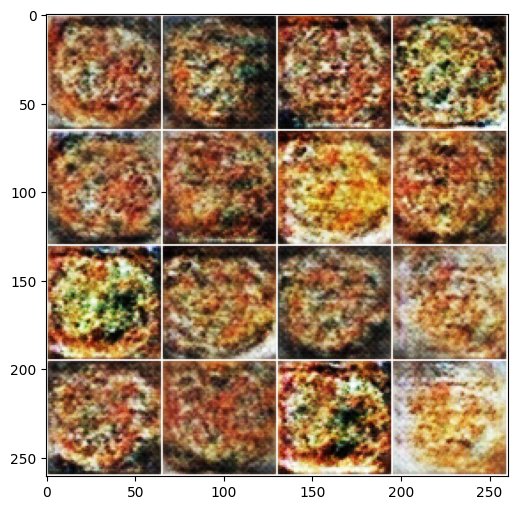

In [62]:
# load model and plot fake pizza
Path_model_G = Path_model + '/BCE/Net_G_epoch_' + str(11) + '.pt'

Net_G = torch.jit.load(Path_model_G)
Net_G.eval();

plot_4_img_grid(Net_G)